In [79]:
import sys
sys.path.append('DubinsLineSegToLineSeg/')
from DubinsLineSegToLineSeg import DubinsL2L

import networkx as nx
from shapely.geometry import Point, LineString, mapping

import numpy as np

import yaml

In [27]:
import networkx as nx
from shapely.geometry import LineString, Point

class Graph_Gstar:
    """
    A class representing a graph for path planning using the G* algorithm.

    Args:
        StartPoint (tuple): Coordinates of the starting point.
        EndPoint (tuple): Coordinates of the end point.
        rho (float): Rho parameter for path smoothing.
        Sectors (int): Number of sectors for angle discretization.
        tolerances (dict): Dictionary containing tolerances for various parameters.

    Attributes:
        GateCounter (int): Counter for gate IDs.
        graph (nx.Graph): NetworkX graph representing the path graph.
        Sectors (int): Number of sectors for angle discretization.
        Start (Point): Shapely Point object representing the starting point.
        End (Point): Shapely Point object representing the end point.
        rho (float): Rho parameter for path smoothing.
        tolerances (dict): Dictionary containing tolerances for various parameters.
        gateGeomList (list): List of gate geometries for collision checking.
        LineStart (list): Coordinates defining the start gate line.
        LineEnd (list): Coordinates defining the end gate line.
        dubUB_nodeCounter (int): Counter for Dubins Upper Bound nodes.
        dubUB_headingList (list): List of heading angles for Dubins Upper Bound.

    Methods:
        None (Constructor only, no methods defined in this snippet)
    """

    def __init__(self, StartPoint: tuple, EndPoint: tuple, rho: float, Sectors: int, tolerances: dict):
        """
        Initializes the Graph_Gstar class instance.

        Args:
            StartPoint (tuple): Coordinates of the starting point.
            EndPoint (tuple): Coordinates of the end point.
            rho (float): Rho parameter for path smoothing.
            Sectors (int): Number of sectors for angle discretization.
            tolerances (dict): Dictionary containing tolerances for various parameters.
        """
        self.GateCounter = 0
        self.graph = nx.Graph()
        self.Sectors = Sectors

        # Initialize starting and ending points
        self.Start = Point(StartPoint[0], StartPoint[1])
        self.End = Point(EndPoint[0], EndPoint[1])
        self.rho = rho
        self.tolerances = tolerances

        # Initialize gate geometries
        self.gateGeomList = []

        # Define gate lines for starting and ending points
        self.LineStart = [(StartPoint[0], StartPoint[1]-0.01), (StartPoint[0], StartPoint[1]+0.01)]
        self.gateGeomList.append(LineString(self.LineStart))

        self.LineEnd = [(EndPoint[0], EndPoint[1]-0.01), (EndPoint[0], EndPoint[1]+0.01)]
        self.gateGeomList.append(LineString(self.LineEnd))

        # Add starting and ending nodes to the graph
        self.graph.add_node(self.GateCounter, id='s', geom=LineString(self.LineStart), point=self.Start, sector=None, x_dist=0)
        StartId = self.GateCounter
        self.GateCounter += 1

        self.graph.add_node(self.GateCounter, id='e', geom=LineString(self.LineEnd), point=self.End, sector=None, x_dist=self.End.distance(self.Start))
        EndId = self.GateCounter
        self.GateCounter += 1

        # Create a direct edge between starting and ending nodes
        eucPath = LineString([self.Start, self.End])
        self.graph.add_edge(StartId, EndId, weight=eucPath.length, geom=eucPath)

        # Initialize various bounds and attributes
        self.eucLB_free, self.dubLB_free = None, None
        self.eucLowerPath, self.dubLowerPath = None, None
        self.eucLowerBound, self.dubLowerBound, self.dubUpperBound = None, None, None
        self.eucLB_time, self.dubLB_time, self.dubUB_time = None, None, None

        self.eucGraph = None
        self.dubUB_graph = None


In [68]:

rho = 1
initial_Sectors = 3
start_conf = (0, 4.5, 0)
end_conf = (16, 4.5, 0)

tolerances = {'continuity': 0.1,
 'angular': 15,
 'polygon_intersection': 0.7,
 'circle_intersection_ratio': 0.5}

G = Graph_Gstar(StartPoint=start_conf, EndPoint=end_conf,rho = rho, Sectors=initial_Sectors, tolerances=tolerances)

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import random

class Map:

    """
    Class implementing simple 2D polygonal obstacles.

    Attributes
    ----------
    StartConf, EndConf : 3-tuple
        List of (x, y, rho) coordinates in the frame of the environment representing the start and end congfiguration of the Dubins vehicle.
    StartPoint, self.EndPoint

    self.ObstacleList

    bounding_box : 4-tuple
        Coordinates of the lower left and upper right corners of the bounding box containing the obstacle.

    Methods
    -------
    generate_polygon_obstacles

    plot
        Displays the polygon on screen.

    """

    def __init__(self, StartConf, EndConf, map_dimensions, nb_obstacles, shape=5):
        self.StartConf, self.EndConf = StartConf, EndConf
        self.StartPoint, self.EndPoint = Point(
            (StartConf[0], StartConf[1])), Point((EndConf[0], EndConf[1]))

        if shape == 0:
            self.ObstacleList = self.generate_circular_obstacles(
                map_dimensions, nb_obstacles)
        elif shape > 2:
            self.ObstacleList = self.generate_polygon_obstacles(
                map_dimensions, nb_obstacles, shape)
        else:
            print("Oops!  Not a valid shape.  Try again...")

        self.map_minx, self.map_miny, self.map_maxx, self.map_maxy = self.MapBounds()
        # self.map_minx, self.map_miny, self.map_maxx, self.map_maxy = 0, 0, map_dimensions[0], map_dimensions[1]

    def MapBounds(self):
        x_min, y_min, x_max, y_max = self.StartPoint.x, np.inf, self.EndPoint.x, 0
        for obstacle in self.ObstacleList:
            _, miny, _, maxy = obstacle.bounds
            if miny < y_min:
                y_min = miny
            if maxy > y_max:
                y_max = maxy
        # bounding_box = box(x_min, y_min, x_max, y_max)
        return x_min, y_min, x_max, y_max

    def generate_polygon_obstacles(self, map_dimensions, nb_obstacles, shape):

        # size = 0.05*map_dimensions[1]
        size = random.uniform(0.08, 0.09)*map_dimensions[0]
        ObstacleList = []

        # for _ in range(nb_obstacles):
        count = 0
        while (count < nb_obstacles):
            # center = np.array([np.random.rand()*map_dimensions[0], np.random.rand()*map_dimensions[1]])

            if count == 0:
                # obstacle at mid map
                center = np.array([map_dimensions[0]/2, map_dimensions[1]/2])
            else:
                # offset by turning radius?
                center = np.array(
                    [np.random.rand()*(map_dimensions[0]), np.random.rand()*(map_dimensions[1])])

            # Simple convex polygons, generated with a radius and randomly selected angles.
            if count < nb_obstacles-3:

                pshape = np.random.randint(3, high=shape)
                angles = sorted((np.random.rand()*2*np.pi for _ in range(pshape)))
                points = np.array(
                    [center + np.array([size*np.cos(angle), size*np.sin(angle)]) for angle in angles])
                polygon = Polygon(points)
            else:
                polygon = Point(center).buffer(random.uniform(0.03, 0.07)*map_dimensions[0])

            if not self.StartPoint.intersects(polygon) and not self.EndPoint.intersects(polygon) and polygon.boundary.distance(self.EndPoint) > 1 and polygon.boundary.distance(self.StartPoint) > 1:
                ObstacleList.append(polygon)
                count += 1

        return ObstacleList


    def plot(self):
        """
        Draws the polygon on screen.
        """

        plt.axis('equal')
        plt.plot(self.StartPoint.x, self.StartPoint.y, 'x', c='black')
        plt.plot(self.EndPoint.x, self.EndPoint.y, 'x', c='black')
        for obstacle in self.ObstacleList:
            x, y = obstacle.exterior.xy
            plt.fill(x, y, c="blue")
        plt.show()

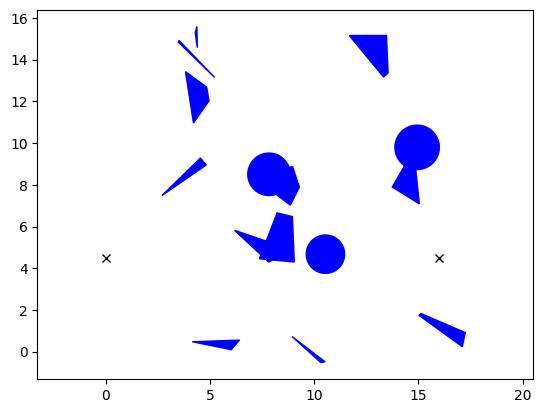

In [200]:
M = Map((0, 4.5, 0), (16, 4.5, np.pi), (16, 16), 15, 5)
M.plot()

In [201]:
def node_id_list(Id, G):
    id_list = []
    for n in list(G.graph.nodes):
        if G.graph.nodes[n]['id'] == Id:
            id_list.append(n)
    return id_list




In [202]:
id_list = node_id_list('s', G)
id_list

[2]

In [203]:
id_list = node_id_list('e', G)
id_list

[3]

In [204]:
def get_shortest_path(start_id, end_id, G):
    ShortestPath, ShortestLength = [], np.inf
    start_id_list, end_id_list = node_id_list(start_id, G), node_id_list(end_id, G)
    for start in start_id_list:
        for end in end_id_list:
            path = nx.shortest_path(G.graph, source=start, target=end, weight='weight', method='dijkstra')
            length = nx.shortest_path_length(G.graph, source=start, target=end, weight='weight', method='dijkstra')
            if length < ShortestLength:
                ShortestPath, ShortestLength = path, length
    return ShortestPath, ShortestLength

In [205]:
ShortestPath, ShortestLength = get_shortest_path('s', 'e', G)

NetworkXNoPath: No path between 2 and 3.

In [ ]:
ShortestPath

In [206]:
ShortestLength

16.0

In [207]:
def is_feasible_connection(Edge, obstacle, Tolerances):
    feasible = True
    ''' if the path is a single line segment '''
    if mapping(Edge['geom'])['type'] == 'LineString':
        if Edge['geom'].within(obstacle) or Edge['geom'].overlaps(obstacle):
            return False
        if Edge['geom'].crosses(obstacle):
            if mapping(obstacle)['type'] == 'Polygon':
                s = Edge['geom'].intersection(obstacle).length
                if s > Tolerances['polygon_intersection']:
                    return False
            else:
                s = Edge['geom'].intersection(obstacle).length
                d = math.sqrt(4*obstacle.area/math.pi)
                if (s/d) > Tolerances['circle_intersection_ratio']:
                    return False
    elif mapping(Edge['geom'])['type'] == 'MultiLineString':
        for segment in list(Edge['geom']):
            if segment.within(obstacle) or segment.overlaps(obstacle):
                return False
            if segment.crosses(obstacle):
                if mapping(obstacle)['type'] == 'Polygon':
                    s = segment.intersection(obstacle).length
                    if s > Tolerances['polygon_intersection']:
                        return False
                else:
                    s = segment.intersection(obstacle).length
                    d = math.sqrt(4*obstacle.area/math.pi)
                    if (s/d) > (s/d) > Tolerances['circle_intersection_ratio']:
                        return False
    return feasible

In [148]:
def is_feasible_path(Path: list, G: Graph_Gstar, obstacleList: list):
    feasible = True
    for i in range(len(Path)-1):
        u = Path[i]
        v = Path[i+1]
        Edge = G.graph.get_edge_data(u, v)

        for obstacle in obstacleList:
            feasible = is_feasible_connection(Edge, obstacle, G.tolerances)
            if not feasible:
                return False

    return feasible

In [128]:
def is_path_exists(StartId, EndId, G):
    start_id_list, end_id_list = node_id_list(StartId, G), node_id_list(EndId, G)
    for s in start_id_list:
        for e in end_id_list:
            if not nx.has_path(G.graph, source=s, target=e):
                return False
    return True

In [130]:
def is_route_continuous(Path, G):
    for i in range(1, len(Path)-1):
        _, b = G.graph.get_edge_data(Path[i-1], Path[i])['geom'].boundary
        c, _ = G.graph.get_edge_data(Path[i], Path[i+1])['geom'].boundary
        if b.distance(c) > G.tolerances['continuity']:
            # print('points: ', b, c)
            # print('distance', b.distance(c))
            return False
    return True

In [134]:
def PlotGstar(shortest_path, G, Map, label, save_path='./images', action='save'):
    """Plots the shortest path on a map, including obstacles and edges.

    Args:
        shortest_path (list): A list of node IDs representing the shortest path.
        G (GstarGraph): The graph to plot.
        Map (Map): The map containing obstacles and start/end points.
        label (str): The title of the plot.
        save_path (str, optional): The path to save the image to. Defaults to './images'.
        action (str, optional): Either 'save' to save the image or 'display' to show it. Defaults to 'save'.
    """
    plt.ioff()
    fig = plt.figure()

    # Plot obstacles
    for obstacle in Map.ObstacleList:
        x, y = obstacle.exterior.xy
        plt.fill(x, y, c="blue")

    # Plot start/end points
    plt.plot(Map.StartPoint.x, Map.StartPoint.y, 'x', c='black')
    plt.plot(Map.EndPoint.x, Map.EndPoint.y, 'x', c='black')

    # Plot edges
    for n in list(G.graph.nodes):
        node = G.graph.nodes[n]
        if mapping(node['geom'])['type'] == 'LineString':
            x, y = node['geom'].xy
            plt.plot(x, y, c="green")
        elif mapping(node['geom'])['type'] == 'MultiLineString':
            for line in list(node['geom']):
                x, y = line.xy
                plt.plot(x, y, c="green")

    # Plot shortest path
    for i in range(len(shortest_path)-1):
        u = shortest_path[i]
        v = shortest_path[i+1]
        edge = G.graph.get_edge_data(u, v)
        if mapping(edge['geom'])['type'] == 'LineString':
            x, y = edge['geom'].xy
            plt.plot(x, y, c="black", linewidth=3)
        elif mapping(edge['geom'])['type'] == 'MultiLineString':
            for line in list(edge['geom']):
                x, y = line.xy
                plt.plot(x, y, c="black", linewidth=3)

    # Set equal axis scaling and title
    plt.axis('equal')
    plt.title(label)

    # Either display or save the plot
    if action == 'display':
        plt.show(block=True)
    elif action == 'save':
        plt.savefig(save_path, format='svg')
    plt.close('all')


In [194]:
EuclideanToDubinsGraph(G, heading_restricted, startAngle = outAngle, goalAngle = inAngle)

In [196]:
G.graph.nodes[2]

{'id': 's',
 'point': <POINT (0 4.5)>,
 'geom': <LINESTRING (0 4.49, 0 4.51)>,
 'sector': (1.5707963267948966, 1.5807963267948966),
 'x_dist': 0}

In [161]:
def EuclideanToDubinsGraph(G, heading_restricted, startAngle, goalAngle):
    sector_list = [(2*np.pi*i/G.Sectors, 2*np.pi*(i+1)/G.Sectors)
                   for i in range(G.Sectors)]
    for n in list(G.graph.nodes):
        if G.graph.nodes[n]['id'] == 's':
            if heading_restricted:
                G.graph.add_node(G.GateCounter, id='s', point=G.graph.nodes[n]['point'], geom=G.graph.nodes[n]['geom'], sector=(
                    startAngle, startAngle+0.01), x_dist=G.graph.nodes[n]['x_dist'])
                G.GateCounter += 1
            else:
                for sector in sector_list:
                    G.graph.add_node(
                        G.GateCounter, id='s', point=G.graph.nodes[n]['point'], geom=G.graph.nodes[n]['geom'], sector=sector, x_dist=G.graph.nodes[n]['x_dist'])
                    G.GateCounter += 1
        elif G.graph.nodes[n]['id'] == 'e':
            if heading_restricted:
                G.graph.add_node(G.GateCounter, id='e', point=G.graph.nodes[n]['point'], geom=G.graph.nodes[n]['geom'], sector=(
                    goalAngle, goalAngle+0.01), x_dist=G.graph.nodes[n]['x_dist'])
                G.GateCounter += 1
            else:
                for sector in sector_list:
                    G.graph.add_node(
                        G.GateCounter, id='e', point=G.graph.nodes[n]['point'], geom=G.graph.nodes[n]['geom'], sector=sector, x_dist=G.graph.nodes[n]['x_dist'])
                    G.GateCounter += 1
        else:
            for sector in sector_list:
                G.graph.add_node(G.GateCounter, id=G.GateCounter,
                                 geom=G.graph.nodes[n]['geom'], sector=sector, x_dist=G.graph.nodes[n]['x_dist'])
                G.GateCounter += 1
        G.graph.remove_node(n)
    G.graph = G.graph.to_directed()
    return G

In [183]:
sector_list = [(2*np.pi*i/3, 2*np.pi*(i+1)/3) for i in range(3)]

In [184]:
sector_list

[(0.0, 2.0943951023931953),
 (2.0943951023931953, 4.1887902047863905),
 (4.1887902047863905, 6.283185307179586)]

In [191]:
list(G.graph.nodes)

[0, 1]

In [192]:
G.graph.nodes[0]

{'id': 's',
 'geom': <LINESTRING (0 4.49, 0 4.51)>,
 'point': <POINT (0 4.5)>,
 'sector': None,
 'x_dist': 0}

In [163]:
def ConnectGates_Dubins(G):
    """
    Function to connect Dubins edges between gates.

    Attributes
    ----------
    Graph : nx.graph()
        A graph containing Gates as nodes.

    Output
    -------
    Graph : nx.graph()
        A graph containing Gates connected using Dubins paths.

    """
    G.graph.clear_edges()
    smallest_gate_x_dist, largest_gate_x_dist = np.inf, 0
    for n in list(G.graph.nodes):
        if G.graph.nodes[n]['x_dist'] < smallest_gate_x_dist:
            smallest_gate_x_dist = G.graph.nodes[n]['x_dist']
        if G.graph.nodes[n]['x_dist'] > largest_gate_x_dist:
            largest_gate_x_dist = G.graph.nodes[n]['x_dist']

    ''' 4/1. Start path'''
    nearest_gates, nearest_gate_dist = [], np.inf
    for n in list(G.graph.nodes):
        if G.graph.nodes[n]['x_dist'] == smallest_gate_x_dist:
            nearest_gate_dist = G.graph.nodes[n]['x_dist']
            nearest_gates.append(n)

    prev_x_dist = nearest_gate_dist
    prev_gates = nearest_gates

    ''' 4/2. Gate connections '''
    while prev_x_dist < largest_gate_x_dist:
        nearest_gates, nearest_gate_dist = [], np.inf
        for n in list(G.graph.nodes):
            if G.graph.nodes[n]['x_dist'] < nearest_gate_dist and G.graph.nodes[n]['x_dist'] > prev_x_dist:
                nearest_gate_dist = G.graph.nodes[n]['x_dist']
                nearest_gates = [n]
            elif G.graph.nodes[n]['x_dist'] == nearest_gate_dist:
                nearest_gates.append(n)

        for a in prev_gates:
            for b in nearest_gates:
                line1 = list(zip(*G.graph.nodes[a]['geom'].coords.xy))
                line2 = list(zip(*G.graph.nodes[b]['geom'].coords.xy))
                sector1 = G.graph.nodes[a]['sector']
                sector2 = G.graph.nodes[b]['sector']
                # try:
                # minLength, minConfStart_1, minConfGoal_1, minPathType, minPathSegLengths = DubinsLineToLine_V2.DubinsLineToLineV2(line1, sector1, line2, sector2, G.rho)
                L2LDub_1 = DubinsL2L.Line2LineDubins(
                    line1, sector1, line2, sector2, G.rho)
                minLength_1, minPath_1 = L2LDub_1.MinDub_L2L()
                minConfStart_1, minConfGoal_1 = list(
                    minPath_1.iniPos)+[minPath_1.iniHead], list(minPath_1.finalPos)+[minPath_1.finalHead]
                path_1 = du.shortest_path(minConfStart_1, minConfGoal_1, G.rho)
                configurations_1, _ = path_1.sample_many(step_size)
                temp_path_1 = list(
                    map(lambda c: (c[0], c[1]), configurations_1))
                temp_path_1.append((minConfGoal_1[0], minConfGoal_1[1]))
                temp_path_1 = LineString(temp_path_1)
                # G.graph.add_edge(a, b, weight=temp_path_1.length, geom=temp_path_1, pathConf=[minConfStart_1, minConfGoal_1], parent_gates=[a, b])
                G.graph.add_edge(a, b, weight=minLength_1, geom=temp_path_1, pathConf=[
                                 minConfStart_1, minConfGoal_1], parent_gates=[a, b])

                # NewLine
                # minLength, minConfStart_2, minConfGoal_2, minPathType, minPathSegLengths = DubinsLineToLine_V2.DubinsLineToLineV2(line2, sector2, line1, sector1, G.rho)
                L2LDub_2 = DubinsL2L.Line2LineDubins(
                    line2, sector2, line1, sector1, G.rho)
                minLength_2, minPath_2 = L2LDub_2.MinDub_L2L()
                minConfStart_2, minConfGoal_2 = list(
                    minPath_2.iniPos)+[minPath_2.iniHead], list(minPath_2.finalPos)+[minPath_2.finalHead]
                path_2 = du.shortest_path(minConfStart_2, minConfGoal_2, G.rho)
                configurations_2, _ = path_2.sample_many(step_size)
                temp_path_2 = list(
                    map(lambda c: (c[0], c[1]), configurations_2))
                temp_path_2.append((minConfGoal_2[0], minConfGoal_2[1]))
                temp_path_2 = LineString(temp_path_2)
                # G.graph.add_edge(b, a, weight=temp_path_2.length, geom=temp_path_2, pathConf=[minConfStart_2, minConfGoal_2], parent_gates=[b, a])
                G.graph.add_edge(b, a, weight=minLength_2, geom=temp_path_2, pathConf=[
                                 minConfStart_2, minConfGoal_2], parent_gates=[b, a])

                # except:
                #     None
        prev_x_dist = nearest_gate_dist
        prev_gates = nearest_gates

    return G

In [175]:
def is_angle_matching(Path, G):
    for i in range(1, len(Path)-1):
        # TO DO: Add boundary point sorting based on x-distace from start point
        AngIn = G.graph.get_edge_data(Path[i-1], Path[i])['pathConf'][1][2]
        AngOut = G.graph.get_edge_data(Path[i], Path[i+1])['pathConf'][0][2]
        pathConfList = sorted([AngIn, AngOut])
        if utils.Angdiff(pathConfList[0], pathConfList[1]) > G.tolerances['angular']*np.pi/180:
            print('Angles', (pathConfList[0], pathConfList[1]))
            print('Angle diff',  utils.Angdiff(
                pathConfList[0], pathConfList[1])*180/np.pi)
            return False
    return True

In [212]:
def ConstructGates(G, Map, Path, graphType='euclidean'):
    ''' 1. Draw gates for obstacles intesecting the path '''
    for i in range(len(Path)-1):
        u, v = Path[i], Path[i+1]
        Edge = G.graph.get_edge_data(u, v)
        # if is_feasible_connection(Edge, ObstacleMap) == False:
        #
        for obstacle in Map.ObstacleList:
            if mapping(Edge['geom'])['type'] == 'LineString':
                # if Edge['geom'].crosses(obstacle):
                if not is_feasible_connection(Edge, obstacle, G.tolerances):
                    # nx.G.graph.remove_edge()
                    G = add_gate(G, Edge['geom'], obstacle, Map, graphType)

            elif mapping(Edge['geom'])['type'] == 'MultiLineString':
                for segment in list(Edge['geom']):
                    # if segment.crosses(obstacle):
                    if not is_feasible_connection(segment, obstacle, G.tolerances):
                        G = add_gate(G, segment, obstacle, Map, graphType)
    return G

In [214]:
def add_gate(G, Edge, Obstacle, Map, Type):
    ''' List of points intersecting the obstacle'''
    points = list(Edge.intersection(Obstacle).boundary)
    ''' Draw gates at midway of points'''
    avg_X, avg_Y = 0, 0
    for p in points:
        avg_X = avg_X + (p.x)/2
        avg_Y = avg_Y + (p.y)/2

    gate_geom = LineString([(avg_X, Map.map_maxy), (avg_X, Map.map_miny)])

    for obs in Map.ObstacleList:
        gate_geom = gate_geom - obs

    # ExistingGateList = []
    # try:
    #     ExistingGateList = [G.graph.nodes[n]['geom'] for n in list(G.graph.nodes)]
    # except AttributeError:
    #     print("Error adding new gates")

    if Type == 'Euclidean':
        if mapping(gate_geom)['type'] == 'LineString':
            # if gate_geom not in ExistingGateList:
            if gate_geom not in G.gateGeomList:
                G.graph.add_node(G.GateCounter, id=G.GateCounter,
                                 geom=gate_geom, sector=None, x_dist=avg_X)
                G.gateGeomList.append(gate_geom)
                G.GateCounter += 1
        elif mapping(gate_geom)['type'] == 'MultiLineString':
            for gate_segment_geom in list(gate_geom):
                # if gate_segment_geom not in ExistingGateList:
                if gate_segment_geom not in G.gateGeomList:
                    G.graph.add_node(G.GateCounter, id=G.GateCounter,
                                     geom=gate_segment_geom, sector=None, x_dist=avg_X)
                    G.gateGeomList.append(gate_segment_geom)
                    G.GateCounter += 1

    elif Type == 'Dubins':
        sector_list = [(2*np.pi*i/G.Sectors, 2*np.pi*(i+1)/G.Sectors)
                       for i in range(G.Sectors)]
        if mapping(gate_geom)['type'] == 'LineString':
            # if gate_geom not in ExistingGateList:
            if gate_geom not in G.gateGeomList:
                for sector in sector_list:
                    G.graph.add_node(G.GateCounter, id=G.GateCounter,
                                     geom=gate_geom, sector=sector, x_dist=avg_X)
                    G.gateGeomList.append(gate_geom)
                    G.GateCounter += 1
        elif mapping(gate_geom)['type'] == 'MultiLineString':
            for gate_segment_geom in list(gate_geom):
                # if gate_segment_geom not in ExistingGateList:
                if gate_segment_geom not in G.gateGeomList:
                    for sector in sector_list:
                        G.graph.add_node(
                            G.GateCounter, id=G.GateCounter, geom=gate_segment_geom, sector=sector, x_dist=avg_X)
                        G.gateGeomList.append(gate_segment_geom)
                        G.GateCounter += 1

    else:
        print('TypeError: Check selected path type')
    return G

In [215]:
# M = Map((0, 2, 0), (5, 2, np.pi), (4, 4), 10, 5)

G = Graph_Gstar(StartPoint=start_conf, EndPoint=end_conf,rho = rho, Sectors=initial_Sectors, tolerances=tolerances)

timeLimit = 1800

heading_restricted = True

imgPath = './PRACTICE/'

with open('./instances/map1/heading.yaml') as heading_yaml:
    headingAngles = yaml.load(heading_yaml, Loader=yaml.FullLoader)

In [216]:
def GstarPaths(Map: Map, G: Graph_Gstar, timeLimit: int, imgPath: str, heading_restricted: bool, headingAngles: float):
    
    
    return G.dubLowerPath, Map, G

In [217]:
dubLB_path, Map, G = GstarPaths(Map= M, G = G, timeLimit = timeLimit, imgPath = imgPath, heading_restricted = heading_restricted, headingAngles = headingAngles)

In [218]:
import time
from copy import deepcopy

short_path_list, short_path_length = get_shortest_path('s', 'e', G)

if heading_restricted:
    outAngle = headingAngles['startAngle']*np.pi/180
    inAngle = headingAngles['goalAngle']*np.pi/180
else:
    outAngle, inAngle = 0, 0

# Compute the Dubins upper bound of the shortest path
delta = 0.001
dubLB_free = DubinsL2L.Line2LineDubins(G.LineStart, (outAngle-delta, outAngle+delta), G.LineEnd, (inAngle-delta, inAngle+delta), G.rho)
G.dubLB_free, minPath = dubLB_free.MinDub_L2L()

# Print the Euclidean and Dubins upper bounds
print("Euclidean Upper Bound (No Obstacles): ", short_path_length)
print("Dubins Upper Bound (No Obstacles): ", G.dubLB_free)

if not is_feasible_path(short_path_list, G, M.ObstacleList):
    improve_bounds = True
else:
    improve_bounds = False

print('### Solving Euclidean Lower Bound ###')
loop = 0
G.eucLB_time, eucBoundStartTime = 0, time.monotonic()
improve_bounds = True

while improve_bounds and (G.eucLB_time < 0.001*timeLimit):
    path_exists = is_path_exists('s', 'e', G)
    path_feasible = is_feasible_path(short_path_list, G, M.ObstacleList)
    path_continuous = is_route_continuous(short_path_list, G)

    if path_exists and path_continuous and path_feasible:
        improve_bounds = False
    else:
        if not path_feasible:
            G = ConstructGates(G, Map, short_path_list,graphType='Euclidean')
            G = ConnectGates_Euclidean(G)
            short_path_list, short_path_length = get_shortest_path('s', 'e', G)

        if not path_continuous:
            G = GraphUpdate_BreakGate(G, short_path_list)
            G = UpdatePath_Euclidean(G)
            short_path_list, short_path_length = get_shortest_path('s', 'e', G)

    print('Path: ', short_path_list)
    G.eucLB_time = time.monotonic()-eucBoundStartTime
    loop += 1
    plotTitle = "Euclidean Lower Bound (length = " + str(round(short_path_length, 3)) + ")"
    PlotGstar(short_path_list, G, Map, plotTitle, save_path=imgPath+'/step_'+str(loop)+'_euc', action='save')

G.eucLowerPath, G.eucLowerBound = short_path_list, short_path_length
G.eucGraph = deepcopy(G.graph)

# print(nx.info(G.graph))
print('Euclidean Lower Bound: ', G.eucLowerBound)
print("Time (Euclindean Lower Bound): ", G.eucLB_time)
plotTitle = "Euclidean Lower Bound (length = " + str(round(G.eucLowerBound, 3)) + ")"
PlotGstar(G.eucLowerPath, G, Map, plotTitle, save_path=imgPath+'/eucLB', action='display')

Euclidean Upper Bound (No Obstacles):  16.0
Dubins Upper Bound (No Obstacles):  17.27956949581917
### Solving Euclidean Lower Bound ###


TypeError: 'MultiPoint' object is not iterable

In [167]:
import dubins as du

step_size = 0.1
bound_resolution = 1

In [181]:
outAngle

1.5707963267948966

In [182]:
inAngle

1.5707963267948966

### Solving Dubins Lower Bound ###


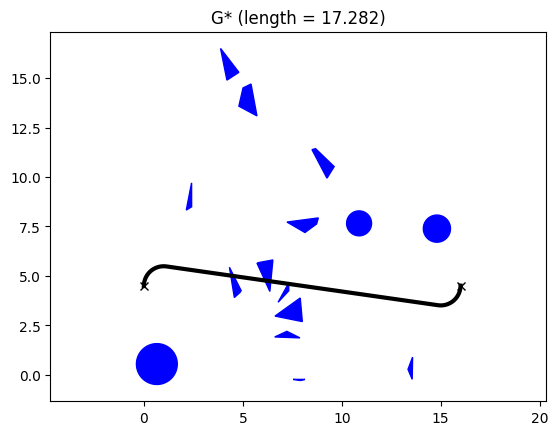

[8, 9]
G* lower bound distance:  17.281851250221237


In [168]:
print('### Solving Dubins Lower Bound ###')
times, Gstar_path_lengths = [], []
dubBoundStartTime = time.monotonic()
improve_bounds = True

G = EuclideanToDubinsGraph(G, heading_restricted, startAngle=outAngle, goalAngle=inAngle)
G = ConnectGates_Dubins(G)

short_path_list, short_path_length = get_shortest_path('s', 'e', G)
times.append(time.monotonic() - dubBoundStartTime)
Gstar_path_lengths.append(short_path_length)
loop += 1

plotTitle = "G* (length = " + str(round(short_path_length, 3)) + ")"
PlotGstar(short_path_list, G, Map, plotTitle, save_path=imgPath +'/step_'+str(loop)+'_dub', action='display')

print(short_path_list)
print('G* lower bound distance: ', short_path_length)
# PlotGstar(short_path_list, G.graph, self.Map, loop, title)
G.dubLB_time = time.monotonic()-dubBoundStartTime

In [176]:
'''### G* lower bounds ###'''
'''### REPLACE EUCLIDEAN PATHS WITH DubLineToLine ###'''
while improve_bounds and (G.dubLB_time < timeLimit):
    path_exists = is_path_exists('s', 'e', G)
    path_feasible = is_feasible_path(short_path_list, G, Map.ObstacleList)
    path_continuous = is_route_continuous(short_path_list, G)
    angle_matching = is_angle_matching(short_path_list, G)

    if path_exists and path_continuous and path_feasible and angle_matching:
        improve_bounds = False
        # break
    else:
        if not path_feasible:
            logging.info('loop {}', loop)
            logging.info('Constructing New Gates...')
            G = ConstructGates(G, Map, short_path_list, graphType='Dubins')
            G = ConnectGates_Dubins(G)
            short_path_list, short_path_length = get_shortest_path('s', 'e', G)
            # PlotGstar(short_path_list, G, Map, title, save_path='./images', action='save')

        if not path_continuous:
            logging.info('Breaking Gates...')
            G = GraphUpdate_BreakGate(G, short_path_list)
            # G = ConnectGates_Dubins(G)
            G = UpdatePath_Dubins(G)
            short_path_list, short_path_length = get_shortest_path('s', 'e', G)
            # PlotGstar(short_path_list, G, Map, title, save_path='./images', action='display')

        if not angle_matching:
            logging.info('Optimizing Angle...')
            G = GraphUpdate_BreakAngle(G, short_path_list)
            ## G = ConnectGates_Dubins(G)
            G = UpdatePath_Dubins(G)
            short_path_list, short_path_length = get_shortest_path('s', 'e', G)
            # PlotGstar(short_path_list, G, Map, title, save_path='./images', action='display')

        G.dubLB_time = time.monotonic()-dubBoundStartTime
        times.append(G.dubLB_time)
        Gstar_path_lengths.append(short_path_length)
        loop += 1
        plotTitle = "G* (length = " + str(round(short_path_length, 3)) + ")"
        PlotGstar(short_path_list, G, Map, plotTitle, save_path=imgPath+'/step_'+str(loop)+'_dub', action='display')


# short_path_list, short_path_length = get_shortest_path('s', 'e', G)
G.dubLowerPath, G.dubLowerBound = short_path_list, short_path_length
print("G* Bound Time: ", G.dubLB_time)
print("G* Path: ", G.dubLowerPath)
print('G* lower bound distance: ', G.dubLowerBound)
plotTitle = "G* (length = " + str(round(G.dubLowerBound, 3)) + ")"

G* Bound Time:  0.24989665699831676
G* Path:  [8, 9]
G* lower bound distance:  17.281851250221237


In [180]:
short_path_list

[8, 9]

In [153]:
is_feasible_path(short_path_list, G, M.ObstacleList)

True

In [122]:
if not is_feasible_path(short_path_list, G, M.ObstacleList):
    improve_bounds = True
else:
    improve_bounds = False

In [123]:
improve_bounds

False